# Seq2Seq 챗봇 구현

## 1. 패키지 로드

In [39]:
import os
import re
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
def set_seed(seed: int = 42) -> None:
    """
    파이썬과 PyTorch 환경에서 랜덤 시드를 고정하여 실험의 재현성 확보
    Args:
        seed (int): 고정할 랜덤 시드 값 (기본값=42)
    Return:
        None
    """
    os.environ['PYTHONHASHSEED'] = str(seed)           # Python 해시 시드 설정
    random.seed(seed)                                  # random 모듈 시드 설정
    np.random.seed(seed)                               # NumPy 모듈 시드 설정
    torch.manual_seed(seed)                            # CPU 텐서 시드 설정
    torch.cuda.manual_seed(seed)                       # 단일 GPU 시드 설정
    torch.cuda.manual_seed_all(seed)                   # 다중 GPU 시드 설정
    torch.backends.cudnn.deterministic = True          # CuDNN을 결정론적으로 설정: GPU 연산 최적화 알고리즘 고정
    torch.backends.cudnn.benchmark = False             # CuDNN 벤치마크 비활성화: 가장 빠른 GPU 연산 알고리즘 탐색 비활성화

# 랜던 시드 고정 실행
set_seed(42)

## 2. 데이터 로드 및 전처리

### 1) 학습 데이터 로드

In [40]:
# 학습 데이터 경로 설정 및 로드
TRAIN_PATH = "data_in/ChatBotData.csv"

train_df = pd.read_csv(TRAIN_PATH, header=0)           # 0번 인덱스를 Header로 지정하여 데이터 로드
train_df.head()                                        # 데이터프레임 헤드(기본값: 5) 출력

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [6]:
# 데이터프레임에서 질문과 답변을 컬럼명을 기준으로 추출
questions, answers = list(train_df["Q"]), list(train_df["A"])

### 2) Vocabulary 생성

In [7]:
# Vocabulary 경로 설정
VOCAB_PATH = "data_in/vocabulary.txt"

In [8]:
# Vocabulary 생성을 위한 토큰 및 인덱스, 필터 정의
## 필터
FILTERS = "([~.,!?\"':;)(])"
CHANGE_FILTER = re.compile(FILTERS)
## 토큰 및 인덱스
PAD, SOS, EOS, UNK = "<PAD>", "<SOS>", "<EOS>", "<UNK>"
PAD_INDEX, SOS_INDEX, EOS_INDEX, UNK_INDEX = 0, 1, 2, 3
MARKER = [PAD, SOS, EOS, UNK]
## 최대 Sequence
MAX_SEQUENCE = 25

## 하이퍼파라미터
EPOCHS = 10
LEARNING_RATE = 1e-3
EMBEDDING_DIM = 256
HIDDEN_DIM = 1024

In [9]:
# Vocabulary 생성
## 단어를 저장할 집합
vocab_set = set()
## 단어 저장
all_sentences = questions + answers
for sentence in (questions + answers):
  filtered_sentence = re.sub(CHANGE_FILTER, "", sentence) # 문장(질문+답변)에 대해 필터링 적용
  for w in filtered_sentence.split():                     # 필터링된 문장을 공백 기준으로 분리(단어 추출)
    vocab_set.add(w)                                      # 단어 저장
vocab_set = MARKER + list(vocab_set)                      # 토큰 추가

# Dictionary 생성
## Vocabulary 크기
vocab_size = len(vocab_set)
## {단어 : 인덱스} 사전
char2idx = {c: i for i, c in enumerate(vocab_set)}
## {인덱스 : 단어} 사전
idx2char = {i: c for i, c in enumerate(vocab_set)}

In [36]:
char2idx

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 '<UNK>': 3,
 '즐거운': 4,
 '끔직한': 5,
 '빌어요': 6,
 '꼬박꼬박': 7,
 '뜨는': 8,
 '아쉬운가봐요': 9,
 '떨어진다고': 10,
 '맞출까': 11,
 '프라이버시니까': 12,
 '해보세요': 13,
 '해보고': 14,
 '궁금할': 15,
 '지워주세요': 16,
 '집착': 17,
 '보인거예요': 18,
 '구해야겠어': 19,
 '가지를': 20,
 '살려주세요': 21,
 '배워볼까': 22,
 '마음에도': 23,
 '설사해': 24,
 '건네봅니다': 25,
 '짝녀가': 26,
 '중독인가봐': 27,
 '진한': 28,
 '다썸이': 29,
 '쓰이겠네요': 30,
 '수학여행때': 31,
 '기울여봐요': 32,
 '자존감을': 33,
 '연애였는데': 34,
 '흘리세요': 35,
 '만나고': 36,
 '와인': 37,
 '보이지': 38,
 '나누는게': 39,
 '천지': 40,
 '괴로운건': 41,
 '껴': 42,
 '뒷모습만': 43,
 '변할': 44,
 '적당히를': 45,
 '슬퍼하고': 46,
 '무엇보다': 47,
 '참아야': 48,
 '없어': 49,
 '공황증': 50,
 '클럽을': 51,
 '였나봐요': 52,
 '맞지': 53,
 '바쁠때': 54,
 '술마셔': 55,
 '지원해보세요': 56,
 '인생인데': 57,
 '삶이': 58,
 '우선순위면': 59,
 '자기몸을': 60,
 '육아를': 61,
 '감정적으로': 62,
 '깨고싶어': 63,
 '헤어진지2주가지났네': 64,
 '오라고': 65,
 '공무원준비를': 66,
 '분들께': 67,
 '기계사서': 68,
 '주제': 69,
 '바지': 70,
 '카풀해볼까': 71,
 '좋아해주는건': 72,
 '지키는': 73,
 '작별': 74,
 '술마시면서': 75,
 '어디있어': 76,
 '헬스장에서': 77,
 '보내겠네요

In [37]:
idx2char

{0: '<PAD>',
 1: '<SOS>',
 2: '<EOS>',
 3: '<UNK>',
 4: '즐거운',
 5: '끔직한',
 6: '빌어요',
 7: '꼬박꼬박',
 8: '뜨는',
 9: '아쉬운가봐요',
 10: '떨어진다고',
 11: '맞출까',
 12: '프라이버시니까',
 13: '해보세요',
 14: '해보고',
 15: '궁금할',
 16: '지워주세요',
 17: '집착',
 18: '보인거예요',
 19: '구해야겠어',
 20: '가지를',
 21: '살려주세요',
 22: '배워볼까',
 23: '마음에도',
 24: '설사해',
 25: '건네봅니다',
 26: '짝녀가',
 27: '중독인가봐',
 28: '진한',
 29: '다썸이',
 30: '쓰이겠네요',
 31: '수학여행때',
 32: '기울여봐요',
 33: '자존감을',
 34: '연애였는데',
 35: '흘리세요',
 36: '만나고',
 37: '와인',
 38: '보이지',
 39: '나누는게',
 40: '천지',
 41: '괴로운건',
 42: '껴',
 43: '뒷모습만',
 44: '변할',
 45: '적당히를',
 46: '슬퍼하고',
 47: '무엇보다',
 48: '참아야',
 49: '없어',
 50: '공황증',
 51: '클럽을',
 52: '였나봐요',
 53: '맞지',
 54: '바쁠때',
 55: '술마셔',
 56: '지원해보세요',
 57: '인생인데',
 58: '삶이',
 59: '우선순위면',
 60: '자기몸을',
 61: '육아를',
 62: '감정적으로',
 63: '깨고싶어',
 64: '헤어진지2주가지났네',
 65: '오라고',
 66: '공무원준비를',
 67: '분들께',
 68: '기계사서',
 69: '주제',
 70: '바지',
 71: '카풀해볼까',
 72: '좋아해주는건',
 73: '지키는',
 74: '작별',
 75: '술마시면서',
 76: '어디있어',
 77: '헬스장에서',
 78: '보

### 3) 학습 데이터 전처리

In [11]:
# 입력 문장에 대한 전처리
enc_sequences = []
for sentence in questions:
  ## 불용어 처리(특수문자, 기호 등)
  sent = re.sub(CHANGE_FILTER, "", sentence)
  idxs = []
  ## 각 단어를 사전에 정의된 인덱스로 변환
  for w in sent.split():
      idxs.append(char2idx.get(w, UNK_INDEX)) # 사전에 없는 토큰의 경우 UNK 토큰으로 대체
  ## 최대 길이를 초과하는 경우 자름
  if len(idxs) > MAX_SEQUENCE:
      idxs = idxs[:MAX_SEQUENCE]
  ## 최대 길이보다 작은 경우 PAD_INDEX로 채움
  idxs += [PAD_INDEX] * (MAX_SEQUENCE - len(idxs))
  ## 전처리된 시퀀스를 리스트에 추가
  enc_sequences.append(idxs)

# 리스트를 Numpy 배열로 변환
enc_inputs = np.array(enc_sequences)

In [12]:
# Teaching Forcing을 위한 Decoder의 입력 데이터에 대한 전처리
dec_inputs = []
for sentence in answers:
  sent = re.sub(CHANGE_FILTER, "", sentence)

  # 디코더 입력은 <SOS> 토큰으로 시작
  idxs = [SOS_INDEX]
  for w in sent.split():
      idxs.append(char2idx.get(w, UNK_INDEX))
  if len(idxs) > MAX_SEQUENCE:
      idxs = idxs[:MAX_SEQUENCE]
  idxs += [PAD_INDEX] * (MAX_SEQUENCE - len(idxs))
  dec_inputs.append(idxs)
dec_inputs = np.array(dec_inputs)

In [13]:
# 출력 문장에 대한 전처리
dec_targets = []
for sentence in answers:
  sent = re.sub(CHANGE_FILTER, "", sentence)
  idxs = []
  for w in sent.split():
      idxs.append(char2idx.get(w, UNK_INDEX))
  if len(idxs) >= MAX_SEQUENCE:
      idxs = idxs[:MAX_SEQUENCE-1] + [EOS_INDEX]
  else:
      idxs.append(EOS_INDEX)
  idxs += [PAD_INDEX] * (MAX_SEQUENCE - len(idxs))
  dec_targets.append(idxs)
dec_targets = np.array(dec_targets)

### 4) 학습 데이터셋 구축

In [38]:
BATCH_SIZE = 256   # 학습데이터의 배치 사이즈
VALID_SPLIT = 0.1  # 검증데이터의 비율(전체 데이터의 10%)

class ChatDataset(Dataset):
  def __init__(self, enc, dec_in, dec_out):
      self.enc = torch.LongTensor(enc)
      self.dec_in = torch.LongTensor(dec_in)
      self.dec_out = torch.LongTensor(dec_out)
  def __len__(self): return len(self.enc)
  def __getitem__(self, i): return self.enc[i], self.dec_in[i], self.dec_out[i]

# 전체 데이터셋 생성
train_dataset = ChatDataset(enc_inputs, dec_inputs, dec_targets)

# 학습/검증 데이터셋 분할
val_size = int(len(train_dataset) * VALID_SPLIT)
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

## 3. 모델 정의

In [21]:
# 학습에 사용할 연산 장치 설정 (GPU가 사용 가능하면 CUDA, 그렇지 않으면 CPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1) Encoder

In [41]:
# Encoder 정의
class Encoder(nn.Module):                                 
    def __init__(self):
        """인코더 초기화 함수"""
        super().__init__()  # nn.Module 초기화

        # 임베딩 레이어: 단어 인덱스를 EMBEDDING_DIM 차원의 임베딩 벡터로 변환
        #    - vocab_size: 어휘 사전 크기(총 토큰 개수)
        #    - EMBEDDING_DIM: 임베딩 벡터 차원
        self.emb = nn.Embedding(vocab_size, EMBEDDING_DIM)

        # GRU 레이어: 임베딩 시퀀스를 은닉 상태로 인코딩
        self.gru = nn.GRU(
            EMBEDDING_DIM,      # 입력 차원
            HIDDEN_DIM,         # 은닉 상태 차원
            batch_first=True    # 입력 shape을 (batch, seq_len, feature)로 설정
        )

    def forward(self, x):
        """
        순전파 함수
        Args:
            x (LongTensor): [batch_size, seq_len] 형태의 입력 시퀀스 (단어 인덱스)
        Returns:
            outputs (Tensor): [batch_size, seq_len, HIDDEN_DIM] - 모든 시점의 출력
            hidden (Tensor): [1, batch_size, HIDDEN_DIM] - 마지막 은닉 상태
        """
        embedded = self.emb(x)               # 입력 인덱스를 임베딩 벡터로 변환
        outputs, hidden = self.gru(embedded) # GRU 연산 수행
        return outputs, hidden               # 출력 시퀀스와 마지막 은닉 상태 반환

### 2) Bahdanau Attention

In [42]:
class BahdanauAttention(nn.Module):                                          
    def __init__(self):                                                      
        super().__init__()
        # 어텐션 score 계산을 위한 선형 변환 레이어 정의
        self.W1 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM) # 인코더 출력에 적용할 가중치
        self.W2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM) # 디코더 은닉 상태에 적용할 가중치
        self.V  = nn.Linear(HIDDEN_DIM, 1)          # score를 1차원 값으로 변환

    def forward(self, hidden, enc_out):                                  
        """
        순전파 함수
        Args:
            hidden  (Tensor): [1, batch_size, HIDDEN_DIM] - 디코더 이전 시점의 은닉 상태
            enc_out (Tensor): [batch_size, seq_len, HIDDEN_DIM] - 인코더의 전체 출력
        Returns:
            c (Tensor): [batch_size, HIDDEN_DIM] - 문맥 벡터 (context vector)
            w (Tensor): [batch_size, seq_len, 1] - 어텐션 가중치
        """
        # hidden 차원 재배치 -> [batch_size, 1, HIDDEN_DIM]
        h = hidden.permute(1, 0, 2)

        # 시퀀스 길이만큼 hidden 복제 → [batch_size, seq_len, HIDDEN_DIM]
        h = h.expand(-1, enc_out.size(1), -1)

        # score 계산: Vᵀ·tanh(W1·enc_out + W2·h)
        #     - W1(enc_out): [batch, seq_len, H]
        #     - W2(h):       [batch, seq_len, H]
        #     - 두 텐서 더한 뒤 tanh → [batch, seq_len, H]
        #     - V(tanh(...)) → [batch, seq_len, 1]
        score = self.V(torch.tanh(self.W1(enc_out) + self.W2(h)))
        w = torch.softmax(score, dim=1)
        c = torch.sum(w * enc_out, dim=1)

        return c, w

### 3) Decoder

In [43]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # 임베딩 레이어: 입력 토큰을 EMBEDDING_DIM 차원 벡터로 매핑
        self.emb = nn.Embedding(vocab_size, EMBEDDING_DIM)
        
        # 어텐션 모듈: 인코더 출력과 디코더 은닉 상태를 이용해 문맥 벡터 생성
        self.att = BahdanauAttention()
        
        # GRU 레이어: [문맥 벡터 + 임베딩] 입력을 받아 HIDDEN_DIM 은닉 상태 출력
        self.gru = nn.GRU(EMBEDDING_DIM + HIDDEN_DIM,
                          HIDDEN_DIM,
                          batch_first=True)
        
        # 출력 레이어: GRU 출력을 vocab_size 차원으로 변환 (로짓 생성)
        self.fc  = nn.Linear(HIDDEN_DIM, vocab_size)

    def forward(self, x, hidden, enc_out):
        """
        순전파 함수
        Args:
            x       (Tensor): [batch, 1] - 현재 입력 토큰 인덱스
            hidden  (Tensor): [1, batch, HIDDEN_DIM] - 이전 시점의 디코더 은닉 상태
            enc_out (Tensor): [batch, seq_len, HIDDEN_DIM] - 인코더 전체 출력
        Returns:
            logits  (Tensor): [batch, vocab_size] - 다음 토큰 예측을 위한 로짓
            hidden  (Tensor): [1, batch, HIDDEN_DIM] - 업데이트된 은닉 상태
        """
        # 임베딩: 입력 토큰 인덱스를 임베딩 벡터로 변환 → [batch, 1, EMBEDDING_DIM]
        x = self.emb(x)
        
        # 어텐션: 인코더 출력과 현재 은닉 상태를 이용해 문맥 벡터 계산 → [batch, HIDDEN_DIM]
        c, _ = self.att(hidden, enc_out)
        
        # 차원 확장: 문맥 벡터를 시퀀스 차원 추가 → [batch, 1, HIDDEN_DIM]
        c = c.unsqueeze(1)
        
        # 입력 결합: 문맥 벡터와 임베딩을 연결 → [batch, 1, EMBEDDING_DIM + HIDDEN_DIM]
        gru_input = torch.cat([c, x], dim=-1)
        
        # GRU 실행 → out: [batch, 1, HIDDEN_DIM], hidden: [1, batch, HIDDEN_DIM]
        out, hidden = self.gru(gru_input, hidden)
        
        # 출력 정리: 시퀀스 차원 제거 → [batch, HIDDEN_DIM]
        out = out.squeeze(1)
        
        # 로짓 생성: 어휘 크기만큼의 출력 벡터 계산 → [batch, vocab_size]
        logits = self.fc(out)
        
        # 다음 토큰 예측용 로짓과 updated 은닉 반환
        return logits, hidden

### 4) Seq2Seq Model

In [25]:
class Seq2Seq(nn.Module):
    def __init__(self):
        super().__init__()
        # 인코더: 질문(소스 시퀀스)을 인코딩
        self.enc = Encoder()

        # 디코더: 인코더의 은닉 정보를 바탕으로 답변(타깃 시퀀스) 생성
        self.dec = Decoder()

    def forward(self, src, trg):
        """
        학습용 순전파 함수 (Teacher Forcing 사용)
        Args:
            src (Tensor): [batch_size, src_len] - 인코더 입력 시퀀스
            trg (Tensor): [batch_size, trg_len] - 디코더 정답 시퀀스
        Returns:
            outputs (Tensor): [batch_size, trg_len, vocab_size] - 시점별 로짓 결과
        """
        # 배치 크기와 타깃 시퀀스 길이
        b, t = trg.size()
        
        # 예측 결과 저장용 텐서
        outputs = torch.zeros(b, t, vocab_size, device=DEVICE)

        # 1) 인코더 실행 → 전체 시퀀스 출력(enc_out), 최종 은닉 상태(hidden)
        enc_out, hidden = self.enc(src)

        # 2) 디코더 첫 입력은 항상 <SOS> 토큰 (Teacher Forcing)
        dec_in = trg[:, 0].unsqueeze(1)  # shape: [batch_size, 1]

        # 3) 시점별로 디코더 실행
        for i in range(1, t):
            # 디코더 한 스텝 수행 → preds: [batch_size, vocab_size], hidden: 업데이트된 은닉
            preds, hidden = self.dec(dec_in, hidden, enc_out)
            # 예측 로짓을 outputs에 저장
            outputs[:, i] = preds
            # 다음 입력(dec_in)에는 실제 정답(trg) 사용 (Teacher Forcing)
            dec_in = trg[:, i].unsqueeze(1)

        return outputs

    def inference(self, src):
        """
        추론용 순전파 함수 (Greedy Decoding)
        Args:
            src (Tensor): [batch_size, src_len] - 인코더 입력 시퀀스
        Returns:
            Tensor: [batch_size, generated_len] - 생성된 토큰 시퀀스
        """
        # 1) 인코더 실행
        enc_out, hidden = self.enc(src)

        # 2) 디코더 초기 입력은 <SOS>
        dec_in = torch.LongTensor([[SOS_INDEX]] * src.size(0)).to(DEVICE)

        # 3) 시퀀스 예측
        seq = []
        # 최대 MAX_SEQUENCE 길이만큼 반복
        for _ in range(MAX_SEQUENCE):
            preds, hidden = self.dec(dec_in, hidden, enc_out)
            # 가장 높은 확률 토큰 선택
            top1 = preds.argmax(1).unsqueeze(1)  # shape: [batch_size,1]
            # EOS를 만나면 중단
            if top1.item() == EOS_INDEX:
                break
            seq.append(top1)
            # 선택된 토큰을 다음 입력으로 사용
            dec_in = top1

        # 시퀀스를 배치 차원으로 연결하여 반환
        return torch.cat(seq, dim=1)  # shape: [batch_size, gen_len]


## 4. 모델 학습

### 1) 모델 초기화

In [27]:
model = Seq2Seq().to(DEVICE)

### 2) Optimizer 정의

In [28]:
# 최적화 함수 정의 (Adam Optimizer)
# - model.parameters(): 학습 대상이 되는 모델의 가중치 파라미터
# - lr: 학습률(learning rate), 가중치가 얼마나 빠르게 갱신될지를 결정
# - Adam: 모멘텀과 적응형 학습률을 결합한 최적화 알고리즘 (빠른 수렴과 안정성 장점)
opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### 3) Loss Function 정의

In [29]:
# 손실 함수 정의 (CrossEntropyLoss)
# - 분류 문제에서 널리 사용되는 손실 함수
# - 입력 로짓(logits)과 정답 클래스 인덱스 간의 차이를 계산
# - ignore_index: 패딩 토큰(PAD_INDEX)은 손실 계산에서 제외하여 모델이 학습하지 않도록 함
#   (이는 시퀀스 길이 통일을 위한 패딩이므로, 의미 없는 정보)
crit = nn.CrossEntropyLoss(ignore_index=PAD_INDEX)

### 4) 학습

In [ ]:
best_val_acc = 0.0
best_model_path = "best_model.pth"

train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []
epoch_bar = tqdm(range(1, EPOCHS + 1), desc='전체 Epoch', unit='epoch')

In [30]:
for epoch in epoch_bar:
    # 모델을 학습 모드로 설정 (Dropout, BatchNorm 활성화)
    model.train()
    train_loss_value = 0.0
    train_accuracy_value = 0.0

    train_iter = tqdm(train_loader, desc=f"[{epoch}/{EPOCHS}] Train", leave=False, unit='batch')
    for idx, (enc, dec_in, dec_out) in enumerate(train_iter, 1):
        # 입력 시퀀스, 디코더 입력, 디코더 정답을 GPU로 이동
        enc, dec_in, dec_out = enc.to(DEVICE), dec_in.to(DEVICE), dec_out.to(DEVICE)
        
        # 누적된 gradient 초기화 (초기화를 진행하지 않으면 이전 Iteration에서 누적된 gradient가 이번 Iteration에 반영됨)
        opt.zero_grad()

        # 모델 순전파 → out: [batch, seq_len, vocab_size]
        out = model(enc, dec_in)

        # 로짓과 정답의 shape을 맞춰 손실 계산
        seq_len = out.size(1)
        logits = out[:, 1: , :].contiguous().view(-1, vocab_size)
        labels = dec_out[:, :seq_len-1].contiguous().view(-1)
        
        # CrossEntropyLoss 계산
        loss = crit(logits, labels)

        # 정확도 계산
        pred = out[:, 1:, :].argmax(2)
        mask = (dec_out[:, :seq_len-1] != PAD_INDEX)
        accuracy = ((pred == dec_out[:, :seq_len-1]) & mask).sum() / mask.sum()

        # 역전파로 gradient 계산
        loss.backward()

        # 파라미터 업데이트
        opt.step()

        train_loss_value += loss.item()
        train_accuracy_value += accuracy.item()

        train_iter.set_postfix(
            loss=f"{train_loss_value/idx:.4f}",
            acc=f"{train_accuracy_value/idx:.4f}"
        )

    train_loss_value /= len(train_loader)
    train_accuracy_value /= len(train_loader)
    train_loss_list.append(train_loss_value)
    train_accuracy_list.append(train_accuracy_value)

    # 평가 모드로 전환 (Dropout 비활성화)
    model.eval()
    val_loss_value = 0.0
    val_accuracy_value = 0.0

    val_iter = tqdm(val_loader, desc=f"[{epoch}/{EPOCHS}] Val  ", leave=False, unit='batch')
    with torch.no_grad():
        for idx, (enc, dec_in, dec_out) in enumerate(val_iter, 1):
            enc, dec_in, dec_out = enc.to(DEVICE), dec_in.to(DEVICE), dec_out.to(DEVICE)

            out = model(enc, dec_in)
            seq_len = out.size(1)
            logits = out[:, 1: , :].contiguous().view(-1, vocab_size)
            labels = dec_out[:, :seq_len-1].contiguous().view(-1)
            loss = crit(logits, labels)

            pred = out[:, 1:, :].argmax(2)
            mask = (dec_out[:, :seq_len-1] != PAD_INDEX)
            accuracy = ((pred == dec_out[:, :seq_len-1]) & mask).sum() / mask.sum()

            val_loss_value += loss.item()
            val_accuracy_value += accuracy.item()

            val_iter.set_postfix(
                loss=f"{val_loss_value/idx:.4f}",
                acc=f"{val_accuracy_value/idx:.4f}"
            )

    val_loss_value /= len(val_loader)
    val_accuracy_value /= len(val_loader)
    val_loss_list.append(val_loss_value)
    val_accuracy_list.append(val_accuracy_value)

    # 최고 성능 모델 저장
    if val_accuracy_value > best_val_acc:
        best_val_acc = val_accuracy_value
        torch.save(model.state_dict(), best_model_path)
        print(f">>> New best model saved: val_acc={best_val_acc:.4f}")

    # epoch 진행률 막대에 결과 출력
    epoch_bar.set_postfix({
        'train_loss': f"{train_loss_value:.4f}",
        'train_acc':  f"{train_accuracy_value:.4f}",
        'val_loss':   f"{val_loss_value:.4f}",
        'val_acc':    f"{val_accuracy_value:.4f}",
    })

전체 Epoch:   0%|          | 0/10 [00:00<?, ?epoch/s]

[1/10] Train:   0%|          | 0/42 [00:00<?, ?batch/s]

[1/10] Val  :   0%|          | 0/5 [00:00<?, ?batch/s]

>>> New best model saved: val_acc=0.2316


[2/10] Train:   0%|          | 0/42 [00:00<?, ?batch/s]

[2/10] Val  :   0%|          | 0/5 [00:00<?, ?batch/s]

>>> New best model saved: val_acc=0.2497


[3/10] Train:   0%|          | 0/42 [00:00<?, ?batch/s]

[3/10] Val  :   0%|          | 0/5 [00:00<?, ?batch/s]

>>> New best model saved: val_acc=0.2766


[4/10] Train:   0%|          | 0/42 [00:00<?, ?batch/s]

[4/10] Val  :   0%|          | 0/5 [00:00<?, ?batch/s]

>>> New best model saved: val_acc=0.3178


[5/10] Train:   0%|          | 0/42 [00:00<?, ?batch/s]

[5/10] Val  :   0%|          | 0/5 [00:00<?, ?batch/s]

>>> New best model saved: val_acc=0.3664


[6/10] Train:   0%|          | 0/42 [00:00<?, ?batch/s]

[6/10] Val  :   0%|          | 0/5 [00:00<?, ?batch/s]

>>> New best model saved: val_acc=0.3942


[7/10] Train:   0%|          | 0/42 [00:00<?, ?batch/s]

[7/10] Val  :   0%|          | 0/5 [00:00<?, ?batch/s]

>>> New best model saved: val_acc=0.4082


[8/10] Train:   0%|          | 0/42 [00:00<?, ?batch/s]

[8/10] Val  :   0%|          | 0/5 [00:00<?, ?batch/s]

>>> New best model saved: val_acc=0.4162


[9/10] Train:   0%|          | 0/42 [00:00<?, ?batch/s]

[9/10] Val  :   0%|          | 0/5 [00:00<?, ?batch/s]

>>> New best model saved: val_acc=0.4176


[10/10] Train:   0%|          | 0/42 [00:00<?, ?batch/s]

[10/10] Val  :   0%|          | 0/5 [00:00<?, ?batch/s]

>>> New best model saved: val_acc=0.4211


## 5. 시각화

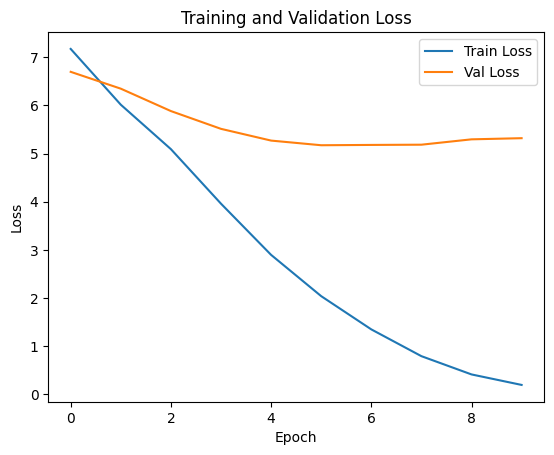

In [31]:
plt.figure()
plt.title("Training and Validation Loss")
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.title("Accuracy")
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(val_accuracy_list, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 6. 테스트

### 1) Best 모델 로드

In [32]:
model = Seq2Seq().to(DEVICE)
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
model.eval()

Seq2Seq(
  (enc): Encoder(
    (emb): Embedding(20705, 256)
    (gru): GRU(256, 1024, batch_first=True)
  )
  (dec): Decoder(
    (emb): Embedding(20705, 256)
    (gru): GRU(1280, 1024, batch_first=True)
    (fc): Linear(in_features=1024, out_features=20705, bias=True)
    (att): BahdanauAttention(
      (W1): Linear(in_features=1024, out_features=1024, bias=True)
      (W2): Linear(in_features=1024, out_features=1024, bias=True)
      (V): Linear(in_features=1024, out_features=1, bias=True)
    )
  )
)

### 2) 텍스트 인코딩 함수 정의

In [33]:
def enc_processing(data: list, dictionary: dict):
    seqs = []
    for seq in data:
        seq = re.sub(CHANGE_FILTER, "", seq)
        idxs = [dictionary.get(w, UNK_INDEX) for w in seq.split()]
        idxs = idxs[:MAX_SEQUENCE]
        idxs += [PAD_INDEX] * (MAX_SEQUENCE - len(idxs))
        seqs.append(idxs)
    return np.array(seqs)

### 3) 추론 함수 정의

In [34]:
def infer(query: str):
    seq = enc_processing([query], char2idx)
    src = torch.LongTensor(seq).to(DEVICE)
    out_idxs = model.inference(src)[0].cpu().numpy()
    return ' '.join(idx2char[i] for i in out_idxs if i not in {PAD_INDEX, EOS_INDEX})

### 4) 추론

In [35]:
print(infer("친구 승진 선물로 뭐가 좋을까?"))

평소에 필요했던 게 좋을 것 같아요
